Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.
✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.

📊 customers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 geolocation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_items 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_payments 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_reviews 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
review_comment_title,87656,88.34
review_comment_message,58247,58.70



📊 products 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
product_category_name,610,1.85
product_name_lenght,610,1.85
product_description_lenght,610,1.85
product_photos_qty,610,1.85
product_weight_g,2,0.01
product_length_cm,2,0.01
product_height_cm,2,0.01
product_width_cm,2,0.01



📊 sellers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
결측값이 있는 행의 데이터 샘플:
                             order_id                       customer_id  \
6    136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44   ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103  0760a852e4e9d

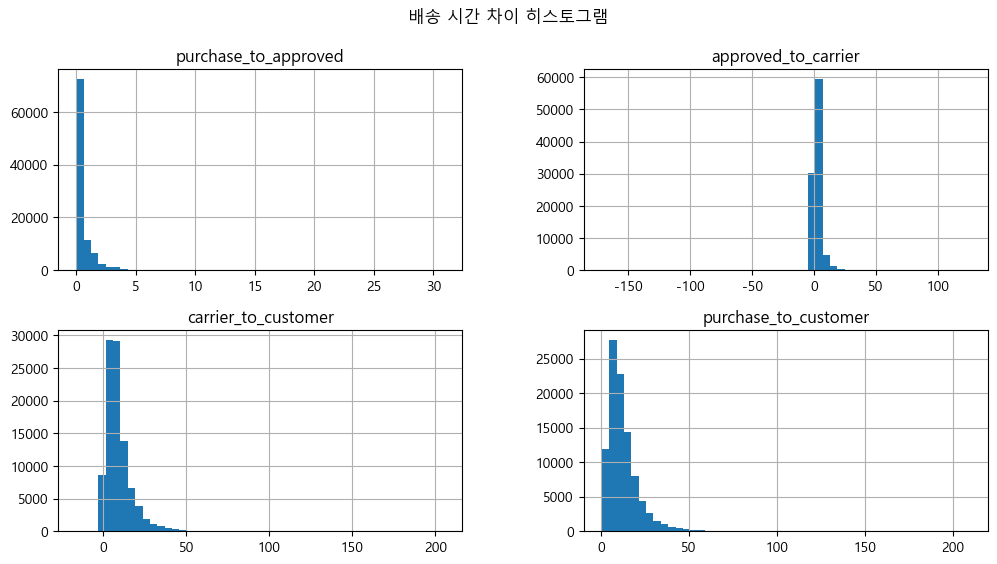

=== Z-score 기준 이상치 비율 (|Z|>3) ===
purchase_to_approved: 2.26%
approved_to_carrier: 1.92%
carrier_to_customer: 1.64%
purchase_to_customer: 1.63%

=== IQR 기준 이상치 비율 ===
purchase_to_approved: 9.26%
approved_to_carrier: 5.80%
carrier_to_customer: 5.26%
purchase_to_customer: 5.08%
'purchase_to_approved'에 대한 마스크 생성 완료.
'approved_to_carrier'에 대한 마스크 생성 완료.
'carrier_to_customer'에 대한 마스크 생성 완료.
'purchase_to_customer'에 대한 마스크 생성 완료.

총 이상치 제거: 78243 -> 78243 (제거된 행 수: 0)

[최종 df_order의 기초 통계량]
       purchase_to_approved  approved_to_carrier  carrier_to_customer  \
count          78243.000000         78243.000000         78243.000000   
mean               0.213960             2.205594             7.855824   
std                0.392342             1.730066             5.227605   
min                0.000000            -1.333345            -2.892384   
25%                0.008681             0.868738             3.970093   
50%                0.012650             1.712755             6.937755   


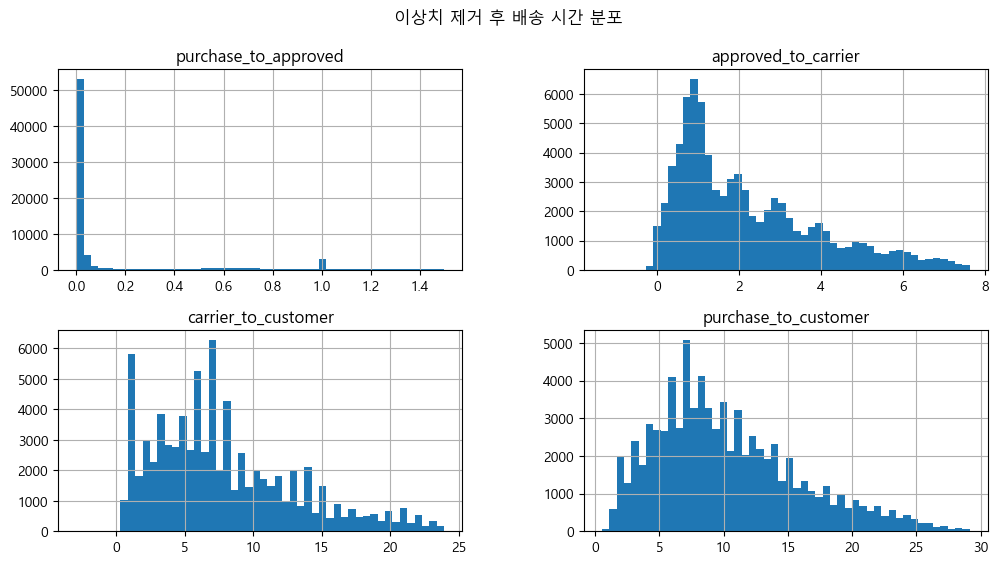

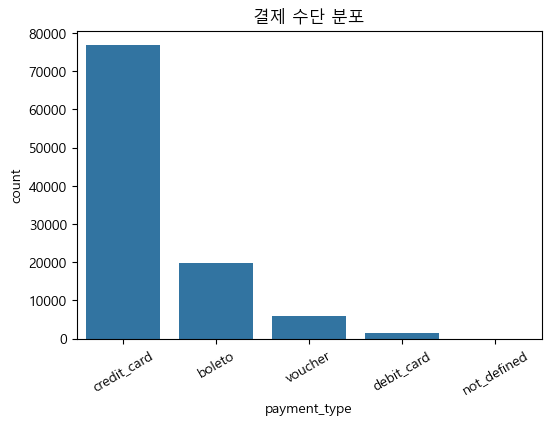


[결제 수단 비율]
payment_type
credit_card    0.739
boleto         0.190
voucher        0.056
debit_card     0.015
not_defined    0.000
Name: proportion, dtype: float64


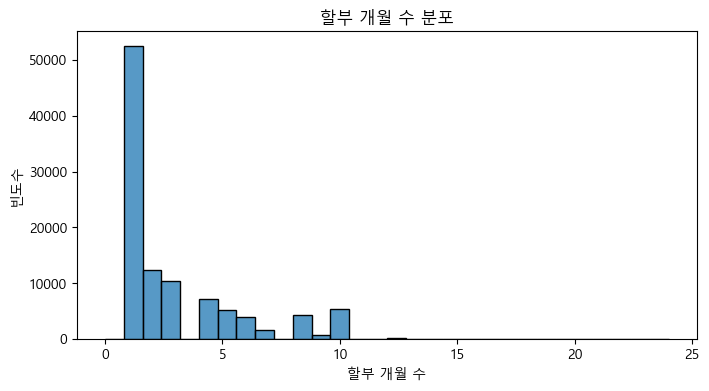


[할부 개월 수 통계]
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


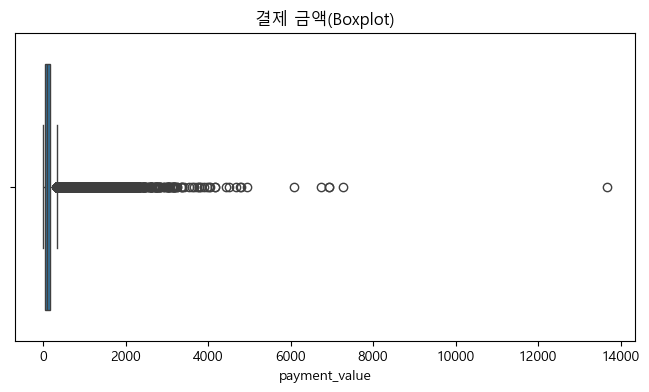

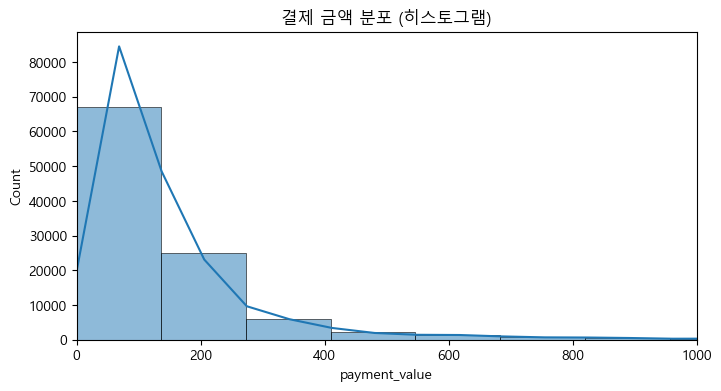


[결제 금액 통계]
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

[결제 금액 이상치 개수] 7981 / 103886 (7.68%)
installment_label
할부     103884
일시불         2
Name: count, dtype: int64
payment_label
유료결제    103877
0원결제         9
Name: count, dtype: int64
                                order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352         

ImportError: cannot import name 'df_join_ocpi' from 'pro1' (c:\Users\mumu1\Desktop\project_movie_data\pro1.py)

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%pip install pandas-summary

# 파일들이 있는 폴더 경로
folder_path = 'C:/Users/mumu1/Desktop/project_movie_data/project_dataset'

# 파일 이름을 변수에 할당
o_df_customers = pd.read_csv(os.path.join(folder_path, 'olist_customers_dataset.csv'), encoding='ISO-8859-1')
o_df_geolocation = pd.read_csv(os.path.join(folder_path, 'olist_geolocation_dataset.csv'), encoding='ISO-8859-1')
o_df_order_items = pd.read_csv(os.path.join(folder_path, 'olist_order_items_dataset.csv'), encoding='ISO-8859-1')
o_df_order_payments = pd.read_csv(os.path.join(folder_path, 'olist_order_payments_dataset.csv'), encoding='ISO-8859-1')
o_df_order_reviews = pd.read_csv(os.path.join(folder_path, 'olist_order_reviews_dataset.csv'), encoding='ISO-8859-1')
o_df_products = pd.read_csv(os.path.join(folder_path, 'olist_products_dataset.csv'), encoding='ISO-8859-1')
o_df_sellers = pd.read_csv(os.path.join(folder_path, 'olist_sellers_dataset.csv'), encoding='ISO-8859-1')

print("✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.")

from pro1 import df_order, df_sellers, df_order_items, df_join_order_cp, df_order_reviews, df_join_ocpi

# from pro1 import df_customers, df_geolocation, df_order_items, df_order_payments, df_order_reviews, df_products, df_sellers

# 과제 3: 상품 카테고리별 수요 예측 및 재고 관리 인사이트
시간에 따른 상품 카테고리별 판매 트렌드를 분석하고, 계절성 패턴을 파악하여 향후 수요 예측과 재고 관리 전략을 수립하세요.